In [1]:
# third party imports
import pandas as pd
# standard library imports
import os
import sys
parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(os.path.abspath(parent_path))
# local imports
from constants import COLUMNS_WE_NEED
from utils.transform_data import transform_reply_to,combine_message_and_reply
from utils.clean_data import clean_text
from utils.helpers import is_it_talk_about_hajez, is_it_give_information,is_question_arabic,draw_word_cloud

c:\Users\nasser\AppData\Local\Programs\Python\Python39\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
data = pd.read_csv('../data/raw.csv') # read the data

In [3]:
data = data[COLUMNS_WE_NEED] # filter the columns we need from the data

# Null handling 

In [4]:
data.isna().sum() # check for null values

id              0
date            0
message      5562
reply_to    53561
dtype: int64

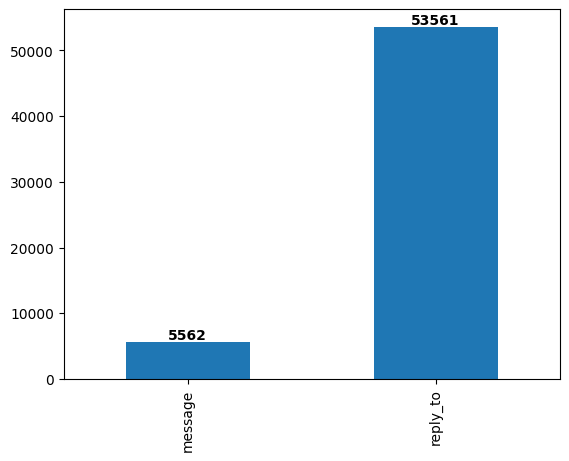

In [5]:
null_count = data.isna().sum()
# delete the zero values
null_count = null_count[null_count != 0]
# plot null_count as a bar chart and print the real values inside the bars
from matplotlib import pyplot as plt
null_count.plot(kind='bar')
for index, value in enumerate(null_count):
    plt.text(index, value, str(value), color='black', fontweight='bold', ha='center', va='bottom') # not in the center
plt.show()


In [6]:
# drop the rows with null values in the 'message' column
data = data.dropna(subset=['message'])

In [7]:
data['reply_text'] = data.apply(transform_reply_to,args=(data,), axis=1) # transform the reply_to column to reply_text column
data = data.drop(columns=['reply_to']) # drop reply_to column because we don't need it anymore

In [8]:
data[data['reply_text']!=""].head(1)

,id,date,message,reply_text
10,428928,2023-03-17 11:41:19+00:00,سالكة,حوارة كيف والحاجز


## Draw wordCloud to see the most frequent words in the dataset 

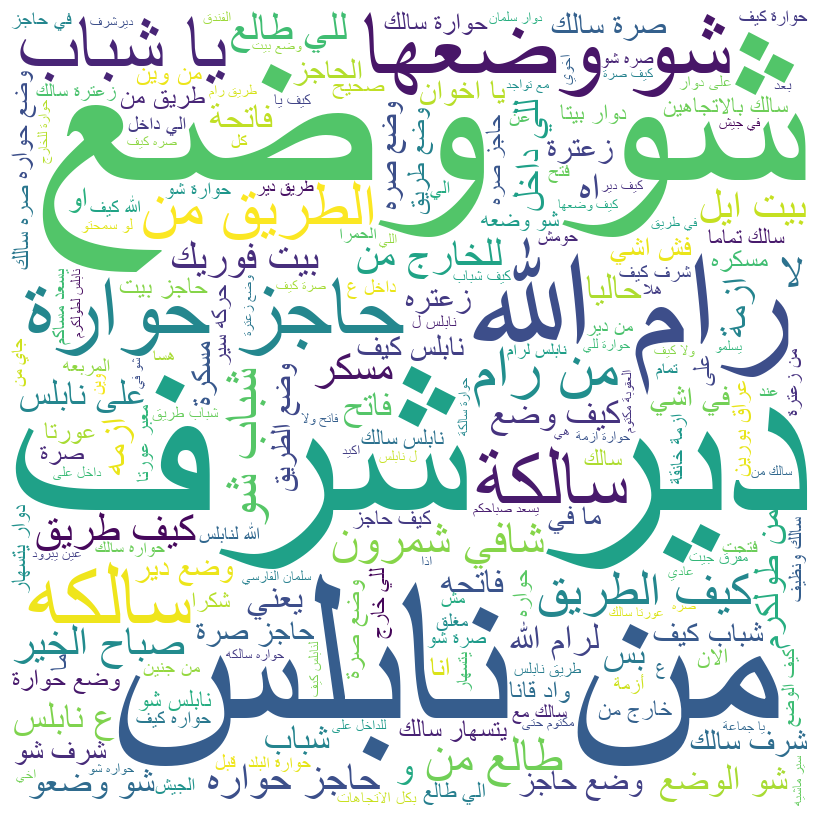

In [9]:
all_text = ' '.join(data['message'].apply(str).tolist())
draw_word_cloud(all_text, 'message_word_cloud')

## Data cleaning 
* Remove phone numbers
* Remove non-Arabic characters

In [10]:
data['message_clean_text'] = data['message'].apply(clean_text)
data['reply_clean_text'] = data['reply_text'].apply(clean_text)

## Message Classification 
* Stetment
* Question


In [11]:
data['message_type'] = data['message_clean_text'].apply(lambda x : 'question' if is_question_arabic(x) else 'statement')
data['reply_type'] = data['reply_clean_text'].apply(lambda x : 'question' if is_question_arabic(x) else 'statement')


In [12]:
data[data['message_type']=='statement'].sample(10)[["message_clean_text","message_type","reply_clean_text","reply_type"]]

,message_clean_text,message_type,reply_clean_text,reply_type
44431,صره,statement,,statement
70297,رمزونات حارس الي فوق سالكات وفاضيات والي تحت س...,statement,,statement
42635,سالك سالك,statement,صرة و دير شرف كيف للخارج؟,question
19885,على دوار دير شرف لا كانوا عند الطنيب بس دون ا...,statement,في جيش اشي,question
58125,صره سالك,statement,,statement
25510,تفتيش,statement,الي طالع من نابلس,statement
10984,صره واد قانا,statement,السؤال الواضح من نابلس على رام الله شو الطرق ا...,question
70430,سالكة انا جاي من جهة اريحا,statement,,statement
60741,زعترة سالكة,statement,,statement
49324,صره ازمه,statement,,statement


# Combine the message with the reply if its there 
* take only the full massage that talk about any Hajez and give information about it , not just asking about it

In [13]:
data['full_text'] = data.apply(combine_message_and_reply, axis=1)

In [14]:
pd.set_option('display.max_colwidth', None)
data.sample(10)[["message_clean_text","message_type","reply_clean_text","reply_type","full_text"]]

,message_clean_text,message_type,reply_clean_text,reply_type,full_text
65459,قاعدين بسكرو المحلات عشان الي صار الصبح بس لسا في حركه والوضع ماشي,question,شو وضع نابلس؟؟,question,
46846,زعترا سالكه بس بعد زعترا ازمه مفرق بيتا,statement,كيف المربعه ياشباب,question,كيف المربعه ياشباب|||زعترا سالكه بس بعد زعترا ازمه مفرق بيتا
43660,حوارة شبه مسكرة للي طالع من نابلس,statement,,statement,حوارة شبه مسكرة للي طالع من نابلس
70747,سالكة,statement,كيف من حواره لا دير شرف طريق تساهر,question,كيف من حواره لا دير شرف طريق تساهر|||سالكة
70244,فش ازمة يعني اه,statement,,statement,
34055,تواجد مستوطنين على حاجز حوارة وأزمة خانقة للخارج من نابلس وحاليا الحاجز واقف لتواجد مسيرة للمستوطنين أما الداخل فيوجهك الجندي للدخول من ساحة الحاجز,statement,,statement,تواجد مستوطنين على حاجز حوارة وأزمة خانقة للخارج من نابلس وحاليا الحاجز واقف لتواجد مسيرة للمستوطنين أما الداخل فيوجهك الجندي للدخول من ساحة الحاجز
48036,بتسأل؟,question,معبر عورتا سالك,statement,
57728,حدا مرق عن حوارة ؟,question,,statement,
14126,صحيح وقوف تام واقفين,statement,اه حتفتح على الاغلب بس ينزلوهن هو الخط مسكر بس على الي طالع كم ناباس,statement,
22779,من وين دخل يعني الطنيب داخل,statement,لا بحكي أنها فتحت هي اخوي فاات هسا,statement,


In [15]:
data[data['full_text']!=''].shape

(19617, 9)

In [24]:
# filter the data to get only the rows that have full_text
data = data[data['full_text']!='']


### save the data in a csv file 

In [25]:
data.to_csv('../data/cleaned_transformed_data.csv', index=False)